# App Subscription Project
**STRV DATA SCIENCE ACADEMY**

by Carolina S. Lopes

Mentor: Niek Mereu

## Defining the business problem

Our client has a financial company, and they've launched an app for their customers to have access to their loans, savings, and other relevant financial data. This app has both a free and a Premium version. Some of the features are unlocked when a user pays for a subscription.

We have a dataset containing some user information and user app behavior, and our job is to predict if an app customer will enroll to Premium or not based on their activity. By having a model that can predict that, the company will be able to create targeted marketing campaigns and customized offers, therefore saving money.

## Data Acquisition

#### Importing libraries

We'll start our analysis by loading all necessary Python libraries required to perform our project:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ---
from itertools import product, combinations
from scipy.stats import chi2_contingency

# ---
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# ---
import warnings
warnings.filterwarnings("ignore")

#### Loading dataset

The project's main dataset is available on the Kaggle platform. 
In order to download it, please check this [link](https://www.kaggle.com/datasets/hkhamnakhalid/customers-to-subscription-through-app-behavior).

After downloading the dataset, we need to provide the filepath in order to read it with the help of pandas library.

In [2]:
df = pd.read_csv('/Users/csergilo/Desktop/strv-ds-academy/app-subscription-strv-academy/datasets/FineTech_appData.csv')

Let's check if the loaded dataset is consistent to what is available on Kaggle page.

In [3]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
0,235136,2012-12-27 02:14:51.273,3,02:00:00,23,"idscreen,joinscreen,Cycle,product_review,ScanP...",15,0,0,0,NaN,0
1,333588,2012-12-02 01:16:00.905,6,01:00:00,24,"joinscreen,product_review,product_review2,Scan...",13,0,0,0,NaN,0
2,254414,2013-03-19 19:19:09.157,1,19:00:00,23,"Splash,Cycle,Loan",3,0,1,0,NaN,1
3,234192,2013-07-05 16:08:46.354,4,16:00:00,28,"product_review,Home,product_review,Loan3,Finan...",40,0,0,1,2013-07-05 16:11:49.513,0
4,51549,2013-02-26 18:50:48.661,1,18:00:00,31,"idscreen,joinscreen,Cycle,Credit3Container,Sca...",32,0,0,1,2013-02-26 18:56:37.841,1


Great! The dataset was uploaded as expected. We can now proceed with the Data Wrangling workflow.

---

## Data Wrangling

The number of rows and columns of the dataframe can be checked with the `pd.DataFrame.shape` method as below, and the output is given in the format (rows, columns)

In [4]:
df.shape

(50000, 12)

Let's see if the column names are indicative of what they represent, and if they are consistent 

In [5]:
df.columns

Index(['user', 'first_open', 'dayofweek', 'hour', 'age', 'screen_list',
       'numscreens', 'minigame', 'used_premium_feature', 'enrolled',
       'enrolled_date', 'liked'],
      dtype='object')

Another important step during Data Wrangling consists in checking the datatypes for each column, and confirm if they correspond to what we expect. In case they don't, we need to cast our data to the correct datatype.

In [6]:
df.dtypes

user                     int64
first_open              object
dayofweek                int64
hour                    object
age                      int64
screen_list             object
numscreens               int64
minigame                 int64
used_premium_feature     int64
enrolled                 int64
enrolled_date           object
liked                    int64
dtype: object

Another important step is to check whether we have any missing values on our columns:

In [7]:
df.isnull().sum()

user                        0
first_open                  0
dayofweek                   0
hour                        0
age                         0
screen_list                 0
numscreens                  0
minigame                    0
used_premium_feature        0
enrolled                    0
enrolled_date           18926
liked                       0
dtype: int64

We can see above that there are many missing entries in the "enrolled_date" column. This makes sense, as no date should appear in this field if the user didn't subscribe to the app Premium features.

Missing data can also appear as entries with null value (0). Depending on the column, this may affect the output of any statistical calculations for that column, as the mean, median, etc.

In the case of our project, a column that could present zero values and mislead our analysis corresponds to the "age". Or are there any babies dealing with FinTech apps already? 🤔

In [8]:
sum([value == 0 for value in df['age']])

0

Okay, that seems good! Just to be sure, let's also check if any users haven't actually interacted with the app (that is, if there's any entry where `df['numscreens']` is equal to zero).

In [9]:
sum([value == 0 for value in df['numscreens']])

0

As nothing seems suspicious with our dataset for now, let's check our unique values! With this step, we can infer if our columns correspond to numerical or categorical variables. And how is that? Well, categorical variables usually have a low amount of unique values, different from numerical variables.

In [10]:
df.nunique()

user                    49874
first_open              49747
dayofweek                   7
hour                       24
age                        78
screen_list             38799
numscreens                151
minigame                    2
used_premium_feature        2
enrolled                    2
enrolled_date           31001
liked                       2
dtype: int64

<details>
<summary> <b> Interesting! Click here to check what this output means <b> </summary>
    

**Categorical variables**

- **user**: unique values corresponding to user ID

- **dayofweek:** values ranging from 0 ("Monday") to 6 ("Sunday"), corresponding to the day of the week

- **hour:** time category from 00:00:00 to 23:00:00 corresponding to the *first_open* variable

- **minigame:** 
    - 0 → user didn't minigame
    - 1 → user played minigame

- **used_premium_feature:** 
    - 0 → user haven't used a Premium feature
    - 1 → Premium feature was used
        
- **liked:** 
    - 0 → user haven't liked/rated the app
    - 1 → user likes the app

**Numerical Variables**

- **age:** user ages

- **numscreens:** number of screens visited by the user

**Dates**

- **first_open:** time at which user created the account

- **enrolled_date:** day at which user subscribed to Premium

    
    
</details>

If we take a look at the output above, it seems that we have some non-unique users in our dataset (as we don't have 50000 unique entries). We should check for duplicate user entries in our dataframe:

In [11]:
df.duplicated(subset=['user']).sum()

126

Ok, 126 user ids are duplicated. Comparing that with the amount of duplicated rows:

In [12]:
df.duplicated().sum()

15

Ok, so from the 126 duplicated users only 15 of them are duplicated rows that we can drop without second thoughts. Let us first remove the duplicated rows, and then check the duplicated users in more detail:

In [13]:
df = df.drop_duplicates()

In [14]:
user = df['user']

df_dupl = df[user.isin(user[user.duplicated()])].sort_values(by = ['user'])
df_dupl.head(6)

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked
20029,2477,2013-04-15 17:45:44.684,0,17:00:00,29,"Loan2,Loan",3,0,1,0,NaN,0
27838,2477,2013-04-15 17:45:44.684,0,17:00:00,27,"Loan2,Loan",3,0,1,0,NaN,0
49052,5867,2013-02-11 08:46:43.530,0,08:00:00,27,"Cycle,Home,Institutions,SelectInstitution,Bank...",18,0,0,0,NaN,1
49397,5867,2013-02-11 08:46:43.530,0,08:00:00,26,"Cycle,Home,Institutions,SelectInstitution,Bank...",18,0,0,0,NaN,1
49509,8767,2013-05-14 23:24:19.949,1,23:00:00,36,"Splash,idscreen,Cycle,product_review,product_r...",22,0,0,1,2013-05-14 23:25:45.033,0
43600,8767,2013-05-14 23:24:19.949,1,23:00:00,34,"Splash,idscreen,Cycle,product_review,product_r...",22,0,0,1,2013-05-14 23:25:45.033,0


We can see that many of the duplicated users have inconsistent ages, and inconsistent data can affect the accuracy of our machine learning algorithm. 

How many non-problematic entries do we have, that is, how many of these rows have actually consistent user ages?

In [15]:
# users = df_dupl['user'].to_numpy()
# print(sum(users[::2] == users[1::2])) # compares both duplicated user entries. all even and odd entries are equal!

ages = df_dupl['age'].to_numpy()
print(sum(ages[::2] == ages[1::2])) # compares both duplicated user entries (even and odd indices)

13


This means that most of our duplicated users are in fact inconsistent in the user ages. Let's then delete all duplicate user entries and updating our dataset:

In [16]:
df = df.drop_duplicates(subset=['user'])

Resetting the dataframe indices:

In [17]:
df.reset_index(drop=True, inplace=True)

Now we're good to go! Focusing back on our categorical and numerical variables: Let's create some new binned categories to enrich our analysis! These categories can be used instead of the numerical columns if they prove themselves to be better adjusted to our ML predictions.

1. New column containing the period the day in which the user created the account

In [18]:
# day periods: (0) night (1) morning (2) afternoon (3) evening

df['hour'] = df['hour'].apply(lambda value: int(value.strip()[0:2]))
df['dayperiod'] = df['hour'].apply(lambda value: ((0 if value >= 0 and value <= 5 else 1) if value <= 11 else 2) if value <= 17 else 3)

2. New column dividing the user age in groups. This may help with unbalanced/skewed data.

In [19]:
# age groups: (0) 18-24 (1) 25-34 (2) 35-44 (3) 45-54 (4) 55-64 (5) 65+

df['age_group'] = df['age'].apply(lambda age: ((((0 if age >= 18 and age <= 24 else 1) if age <= 34 else 2) if age <= 44 else 3) if age <= 54 else 4) if age <= 64 else 5)

3. New column counting the days it took for the user to subscribe to Premium after creating their accounts

In [20]:
df.enrolled_date = pd.to_datetime(df.enrolled_date)
df.first_open = pd.to_datetime(df.first_open)

df['days_to_enroll'] = round((df.enrolled_date - df.first_open) / pd.Timedelta(days=1))

Getting back to our dataframe, there's one column that needs our special attention: the "screen_list" column. If we scroll up a bit, we can see that this column has more than 38000 unique values. That is because the entries correspond to strings with all screens that a given user has visited. Since we have many different screens that the user can interact with, the number of their possible combinations is too high.

To start using this data, we can first turn the "screen_list" entries into actual lists with the screen names:

In [21]:
df['screen_list'] = df['screen_list'].apply(lambda x: x.split(','))

And then check with how many and which unique screen names we're actually dealing with:

In [22]:
list_items = df['screen_list'].notnull() # to only consider non-null entries
all_screens = set()

# Looping through the true/false values that correspond to our non-null and null lists in each row:
for i, item in enumerate(list_items): 
        
    if item == True:

            # variable corresponding to the list itself
            entry = df['screen_list'][i]

            for j in entry:

                # adds the screen contained in the list to a set to avoid repeated values
                all_screens.add(j)

In [23]:
total_screens = len(all_screens)
total_screens

137

So our app has 137 different screens. If you run the cell below, you can check what are these screens:

In [24]:
all_screens

{'About',
 'AccountView',
 'AddProperty',
 'AddVehicle',
 'AdverseActions',
 'Alerts',
 'BVPlaidLinkContainer',
 'BVStats',
 'BankVerification',
 'BoostFriendsList',
 'CC1',
 'CC1Category',
 'CC3',
 'CameraScreen',
 'CommunityAndInvites',
 'ContactInfoConfirm',
 'Credit1',
 'Credit2',
 'Credit3',
 'Credit3Alerts',
 'Credit3CTA',
 'Credit3Container',
 'Credit3Dashboard',
 'Credits',
 'Cycle',
 'EditProfile',
 'EmploymentInfo',
 'EmploymentSummary',
 'Finances',
 'FindFriendsCycle',
 'ForgotPassword',
 'GroupedInstitutions',
 'History',
 'Home',
 'IdAndSelfieCameraScreen',
 'IdentityVerification',
 'InstantLoanSSN',
 'InstantOfferCreateAccount',
 'Institutions',
 'LLLoanAmount',
 'LandingScreen',
 'Leaderboard',
 'ListPicker',
 'Loan',
 'Loan1',
 'Loan2',
 'Loan3',
 'Loan4',
 'LoanAppAgreement',
 'LoanAppBankInfo',
 'LoanAppConfirmWithdrawal',
 'LoanAppDenied',
 'LoanAppESign',
 'LoanAppLoan4',
 'LoanAppPaymentSchedule',
 'LoanAppPromoCode',
 'LoanAppReasons',
 'LoanAppRequestAmount',
 '

From the output, we can see that there are many similar screens. For example, the screens starting with "Credit":

In [25]:
[i for i in all_screens if i.startswith("Credit")]

['Credits',
 'Credit3Alerts',
 'Credit1',
 'Credit3Container',
 'Credit3CTA',
 'Credit2',
 'Credit3Dashboard',
 'Credit3']

We can group these screens in order to reduce some redundant data. Let's define a function that will do this for us:

In [26]:
# this function renames the screen according to the specified string that it begins with

def group_screens(group):

    for i, item in enumerate(df['screen_list']):

        for j, jtem in enumerate((pd.Series(df['screen_list'][i])).str.startswith(group)):

            if jtem == True:

                df['screen_list'][i][j] = group

The function `group_screens` is able to replace all entries starting with a given string by this very same string. For example: if we call the function `group_screens('Credit')`, it will replace all strings starting with "Credit" by "Credit".

In [27]:
group_screens('Credit')

We can do the same for other categories:

In [28]:
screens_to_group = ['Loan', 'Profile', 'Saving', 'Verify', 'product_review']

for s in screens_to_group:
    
    group_screens(s)

We can now count the number of screens in each list entry in the "screen_list" column and compare it with the "numscreens" column:

In [29]:
df['total_screens'] = df['screen_list'].apply(lambda value: len(value))

Our dataset is now as follows:

In [30]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,enrolled_date,liked,dayperiod,age_group,days_to_enroll,total_screens
0,235136,2012-12-27 02:14:51.273,3,2,23,"[idscreen, joinscreen, Cycle, product_review, ...",15,0,0,0,NaT,0,0,0,NaN,13
1,333588,2012-12-02 01:16:00.905,6,1,24,"[joinscreen, product_review, product_review, S...",13,0,0,0,NaT,0,0,0,NaN,11
2,254414,2013-03-19 19:19:09.157,1,19,23,"[Splash, Cycle, Loan]",3,0,1,0,NaT,1,3,0,NaN,3
3,234192,2013-07-05 16:08:46.354,4,16,28,"[product_review, Home, product_review, Loan, F...",40,0,0,1,2013-07-05 16:11:49.513,0,2,1,0.0,17
4,51549,2013-02-26 18:50:48.661,1,18,31,"[idscreen, joinscreen, Cycle, Credit, ScanPrev...",32,0,0,1,2013-02-26 18:56:37.841,1,3,1,0.0,19


Elementary, my dear Watson. It seems that "screen_list" and "numscreens" are inconsistent. For now, we'll keep both columns. Later, we'll check which one is more adequated to train our model.

To enrich our analysis, we can also add some numerical columns to our dataset corresponding to specific screen counts of the "screen_list", that is: "How many screens belonging to this screen group has the user visited?"

In [31]:
def count_screens(name):
    
    screen_count = []
    
    for i, item in enumerate(df['screen_list']):
        
        name_list = []

        for j, jtem in enumerate((pd.Series(df['screen_list'][i]))):
            
            # if a screen contained in row list belongs to the specified group, we add it to a new list "name_list"

            if jtem == name:

                name_list.append(name)
    
        # calculates the length of thr list containing repeated screens 
        
        screen_count.append(len(name_list))
        
    return(screen_count)

We can provide a list with the screen names that we want to check:

In [32]:
screens_to_group = ['Credit', 'Loan', 'Profile', 'Saving', 'Verify', 'product_review']
screen_count = []

for s in screens_to_group:
        
    screen_count.append(count_screens(s))

In [33]:
df['credit_screens'] = screen_count[0]
df['loan_screens'] = screen_count[1]
df['prof_screens'] = screen_count[2]
df['sav_screens'] = screen_count[3]
df['ver_screens'] = screen_count[4]
df['prod_rvw_screens'] = screen_count[5]

In [34]:
df.head()

,user,first_open,dayofweek,hour,age,screen_list,numscreens,minigame,used_premium_feature,enrolled,...,dayperiod,age_group,days_to_enroll,total_screens,credit_screens,loan_screens,prof_screens,sav_screens,ver_screens,prod_rvw_screens
0,235136,2012-12-27 02:14:51.273,3,2,23,"[idscreen, joinscreen, Cycle, product_review, ...",15,0,0,0,...,0,0,NaN,13,0,1,1,0,3,1
1,333588,2012-12-02 01:16:00.905,6,1,24,"[joinscreen, product_review, product_review, S...",13,0,0,0,...,0,0,NaN,11,0,1,0,0,4,2
2,254414,2013-03-19 19:19:09.157,1,19,23,"[Splash, Cycle, Loan]",3,0,1,0,...,3,0,NaN,3,0,1,0,0,0,0
3,234192,2013-07-05 16:08:46.354,4,16,28,"[product_review, Home, product_review, Loan, F...",40,0,0,1,...,2,1,0.0,17,3,1,0,0,3,2
4,51549,2013-02-26 18:50:48.661,1,18,31,"[idscreen, joinscreen, Cycle, Credit, ScanPrev...",32,0,0,1,...,3,1,0.0,19,2,1,0,0,4,3


Finally, we can drop the columns that won't be used to train our ML model.

In [35]:
df = df.drop(['user', 'first_open', 'screen_list', 'enrolled_date', 'days_to_enroll'], axis=1)

## Exploratory Data Analysis

Now that our dataset is cleaner and easier to work with, let's check the correlation between our numerical variables. We can start by defining a smaller dataframe derived from our main dataframe, including only numerical data:

In [36]:
num_feat = ['age', 'numscreens','total_screens', 
             'credit_screens', 'loan_screens', 'prof_screens', 'sav_screens', 'ver_screens', 'prod_rvw_screens']

targets = ['enrolled']

In [37]:
df_num = df[num_feat]

In [38]:
df_num.head()

,age,numscreens,total_screens,credit_screens,loan_screens,prof_screens,sav_screens,ver_screens,prod_rvw_screens
0,23,15,13,0,1,1,0,3,1
1,24,13,11,0,1,0,0,4,2
2,23,3,3,0,1,0,0,0,0
3,28,40,17,3,1,0,0,3,2
4,31,32,19,2,1,0,0,4,3


We can use now the `DataFrame.describe()` method in order to obtain some key statistical parameters of our columns:

In [39]:
df_num.describe()

,age,numscreens,total_screens,credit_screens,loan_screens,prof_screens,sav_screens,ver_screens,prod_rvw_screens
count,49874.000000,49874.000000,49874.000000,49874.000000,49874.000000,49874.000000,49874.000000,49874.000000,49874.000000
mean,31.713157,21.098849,12.985323,0.930344,0.794322,0.454906,0.371897,2.461102,2.644925
std,10.803037,15.726940,7.095013,1.219565,0.722807,1.348168,1.442486,2.092640,2.659094
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,10.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,18.000000,12.000000,0.000000,1.000000,0.000000,0.000000,3.000000,2.000000
75%,37.000000,28.000000,17.000000,2.000000,1.000000,0.000000,0.000000,4.000000,4.000000
max,101.000000,325.000000,79.000000,5.000000,9.000000,11.000000,13.000000,10.000000,23.000000


By taking a look at the table above, we have a glimpse of some interesting facts about our dataset, as:

1. The app users have a mean age of 31 years old, and the median of the ages is 29. This means our age data is most likely lightly right-skewed.

2. There's an user with 101 years old! 🧓

3. As we had seen before, the "numscreens" and "total_screens" columns are not consistent. The maximum value of both, for example, are really different.

4. One of the screen groups that users most visit is the "product_review" group. "savings" and "profile" screens, on the other hand, are not that popular.

Now the method `pd.DataFrame.corr`is able to calculate the correlation between our numerical features. Let's plot the outcome in a heatmap:

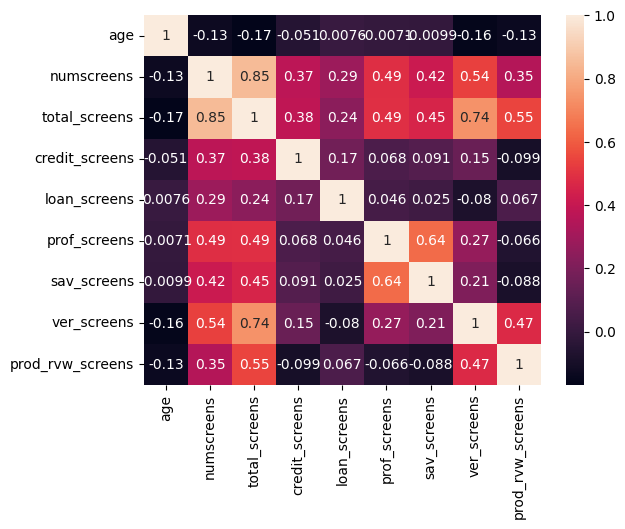

In [40]:
sns.heatmap(df_num.corr(method="pearson"), annot=True);

Here are some conclusions that we can draw from the heatmap:

1. Although "numscreens" and "total_screens" are inconsistent, they're highly correlated, meaning that we will, as expected, need to choose one of them depending on the Machine Learning model we decide to use in our analysis.

2. User age is poorly correlated to the user screen behaviors

3. Profile screens are considerably correlated with savings screens.

4. All screen groups are somewhat correlated with "numscreens" and "total_screens", which makes sense.

We can also check the pairplot that includes all numerical features and the categorical feature "enrolled" in the y-axis. This can give us a glimpse of the correlation between them:

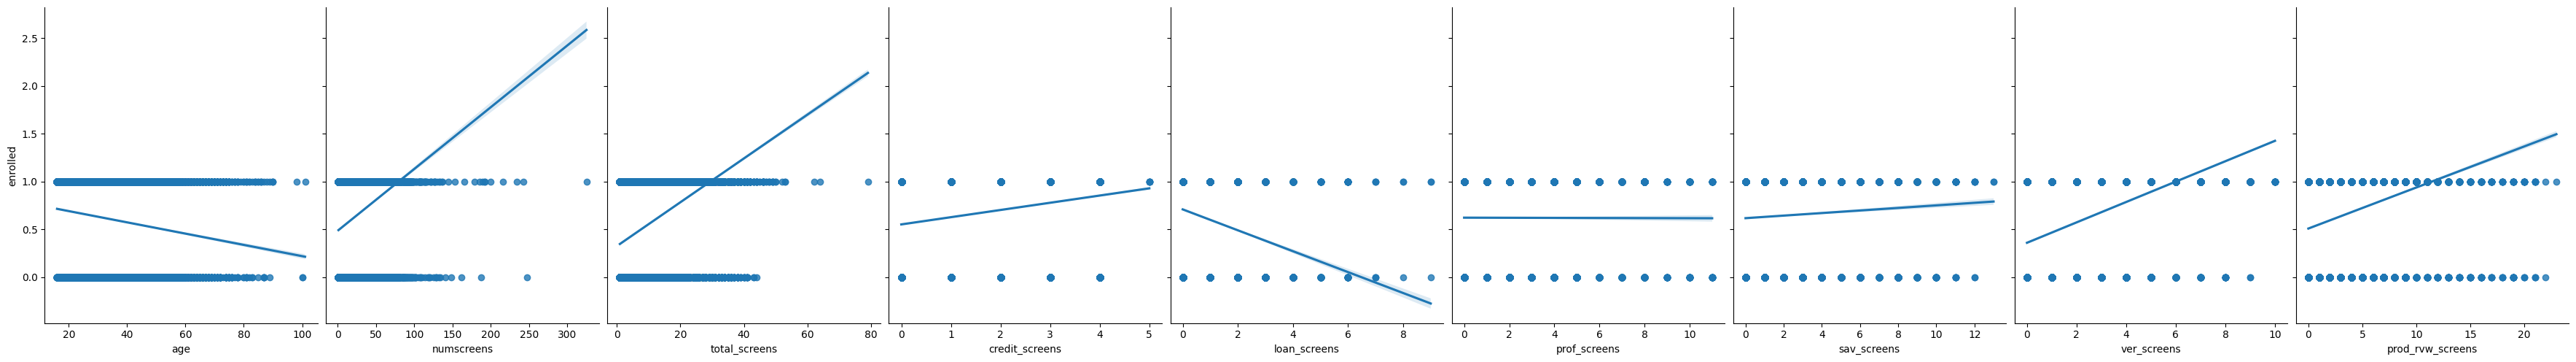

In [41]:
variables = num_feat + targets

df_num_enrolled = df[variables]

sns.pairplot(df_num_enrolled, x_vars=num_feat, y_vars=targets[0], height=5, aspect=0.8, kind="reg");

This is vey interesting! We can see that the data in our regression plots is almost not spread, and that "prof_screens" and "sav_screens" have very little to no correlation with the label "enrolled". 

From our conclusions above, let's drop a feature that is irrelevant to our ML model:

In [ ]:
# df = df.drop(['prof_screens'] , axis=1)

Now, let's check the correlation between our categorical variables, which play a big role in our dataframe. 

The correlation between two categorical variables is calculated in a different manner compared to the correlation between a numerical and a categorical variable. In the next steps, we'll calculate the Chi-square test of independence between all pairs of categorical variables. The Chi-Square test returns an array of parameters used to understand the correlation between two variables in the following manner:

**Chi-square test**

Let's consider we have an Hypothesis H0, stating that two variables are not correlated and an Hypothesis H1, which states that both are correlated. We then perform the chi-square test and obtain the p-value, which will indicate which hypothesis is most likely to be true: 

* If `p > 0.05`, H1 considered as true and H0 is rejected. 
* If `p < 0.05`, H1 is discarded and we consider H0 as true.

In [42]:
df.head()

,dayofweek,hour,age,numscreens,minigame,used_premium_feature,enrolled,liked,dayperiod,age_group,total_screens,credit_screens,loan_screens,prof_screens,sav_screens,ver_screens,prod_rvw_screens
0,3,2,23,15,0,0,0,0,0,0,13,0,1,1,0,3,1
1,6,1,24,13,0,0,0,0,0,0,11,0,1,0,0,4,2
2,1,19,23,3,0,1,0,1,3,0,3,0,1,0,0,0,0
3,4,16,28,40,0,0,1,0,2,1,17,3,1,0,0,3,2
4,1,18,31,32,0,0,1,1,3,1,19,2,1,0,0,4,3


To obtain the p-value between all possible pairs of categorical features, we first create a new dataframe containing only the categorical variables:

In [43]:
categorical = ['enrolled', 'dayofweek', 'hour', 'minigame', 'used_premium_feature', 'liked', 'dayperiod', 'age_group']

df_cat = df[categorical]
df_cat.head()

,enrolled,dayofweek,hour,minigame,used_premium_feature,liked,dayperiod,age_group
0,0,3,2,0,0,0,0,0
1,0,6,1,0,0,0,0,0
2,0,1,19,0,1,1,3,0
3,1,4,16,0,0,0,2,1
4,1,1,18,0,0,1,3,1


Next, we build a list with the help of `itertools.combinations` function. This function can create a list of tuples with all possible and different pairs of features, as follows:

In [44]:
cat_combinations = combinations(categorical, r=2)
all_cat = list(cat_combinations)
all_cat

[('enrolled', 'dayofweek'),
 ('enrolled', 'hour'),
 ('enrolled', 'minigame'),
 ('enrolled', 'used_premium_feature'),
 ('enrolled', 'liked'),
 ('enrolled', 'dayperiod'),
 ('enrolled', 'age_group'),
 ('dayofweek', 'hour'),
 ('dayofweek', 'minigame'),
 ('dayofweek', 'used_premium_feature'),
 ('dayofweek', 'liked'),
 ('dayofweek', 'dayperiod'),
 ('dayofweek', 'age_group'),
 ('hour', 'minigame'),
 ('hour', 'used_premium_feature'),
 ('hour', 'liked'),
 ('hour', 'dayperiod'),
 ('hour', 'age_group'),
 ('minigame', 'used_premium_feature'),
 ('minigame', 'liked'),
 ('minigame', 'dayperiod'),
 ('minigame', 'age_group'),
 ('used_premium_feature', 'liked'),
 ('used_premium_feature', 'dayperiod'),
 ('used_premium_feature', 'age_group'),
 ('liked', 'dayperiod'),
 ('liked', 'age_group'),
 ('dayperiod', 'age_group')]

Now, we calculate every p-value for the list items. To do that, we first need to create a crosstab for each category pair. With the help of `chi2_contingency` function of the `scipy.stats` module, we can obtain the p-values, as the p-value corresponds to the second item of the function output:

In [45]:
result = []

for cat in all_cat:
    
    cat_crosstab = pd.crosstab(df_cat[cat[0]], df_cat[cat[1]])
    
    p_value = chi2_contingency(cat_crosstab)[1]
                    
    result.append((cat[0],cat[1], p_value))
        
result

[('enrolled', 'dayofweek', 6.833634078971159e-05),
 ('enrolled', 'hour', 3.062701176325287e-101),
 ('enrolled', 'minigame', 3.597655788621121e-120),
 ('enrolled', 'used_premium_feature', 8.075354394513489e-32),
 ('enrolled', 'liked', 0.11999900941927215),
 ('enrolled', 'dayperiod', 9.570024750080955e-54),
 ('enrolled', 'age_group', 2.8506099470935414e-203),
 ('dayofweek', 'hour', 2.1708143775683985e-06),
 ('dayofweek', 'minigame', 0.11556087049073556),
 ('dayofweek', 'used_premium_feature', 0.0008712486220062564),
 ('dayofweek', 'liked', 0.11520353667228082),
 ('dayofweek', 'dayperiod', 4.098458915115461e-10),
 ('dayofweek', 'age_group', 0.001444483290946781),
 ('hour', 'minigame', 0.2138478958751414),
 ('hour', 'used_premium_feature', 6.961995825891043e-10),
 ('hour', 'liked', 0.5401362221675338),
 ('hour', 'dayperiod', 0.0),
 ('hour', 'age_group', 1.7414323257761416e-06),
 ('minigame', 'used_premium_feature', 1.6712447726751414e-130),
 ('minigame', 'liked', 0.006014091598988705),
 ('

The most relevant fact that we get from this output is that the "liked" parameter is not correlated with "enrolled", meaning this feature is not relevant to build our model.

In [46]:
df = df.drop(['liked'] , axis=1)

**Data Plots**

It is also of great importance to understand the data we're working with. By checking the countplots of some features, we can have an idea of how they behave.

Let's start with the plots regarding the time and day of week that users created their accounts: 

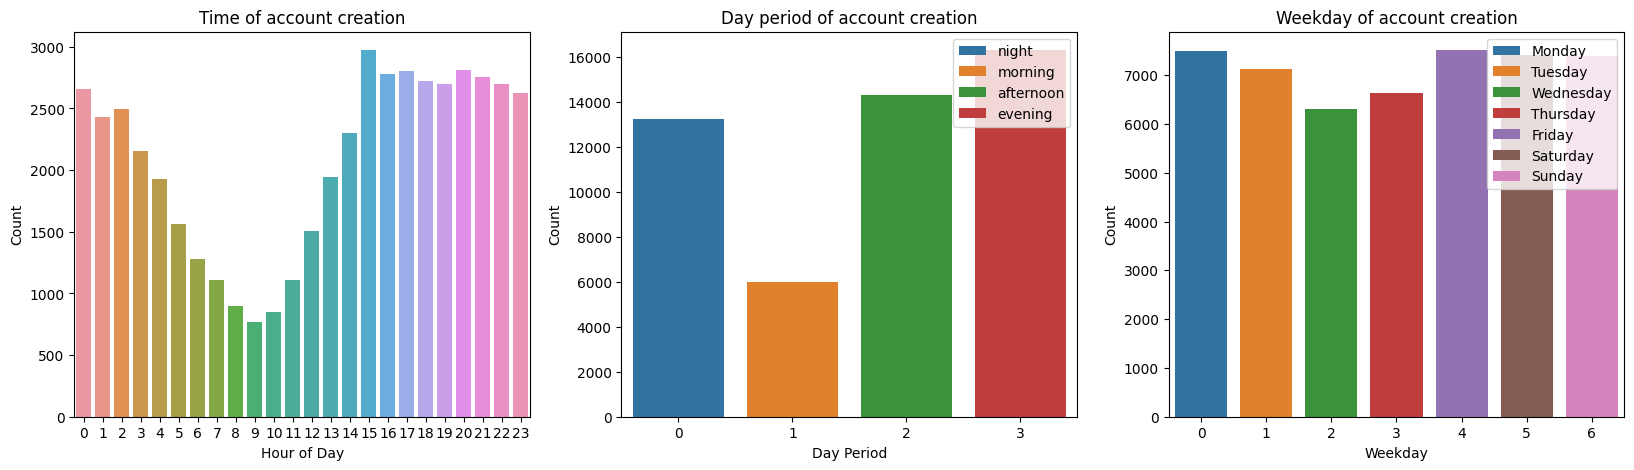

In [47]:
_, axes = plt.subplots(1, 3, figsize=(20, 5))

plot_hour = sns.countplot(data=df, x='hour', ax=axes[0]).set(
                title='Time of account creation', 
                xlabel='Hour of Day', 
                ylabel='Count'
            )

plot_period = sns.countplot(data=df, x='dayperiod', ax=axes[1], hue='dayperiod', dodge=False)

plot_period.set(
                title='Day period of account creation', 
                xlabel='Day Period', 
                ylabel='Count'
            )

legend_labels, _= plot_period.get_legend_handles_labels()
plot_period.legend(legend_labels, ['night','morning','afternoon', 'evening'])

plot_dayofweek = sns.countplot(data=df, x='dayofweek', ax=axes[2], hue='dayofweek', dodge=False);

plot_dayofweek.set(
                title='Weekday of account creation', 
                xlabel='Weekday', 
                ylabel='Count'
            )

legend_labels, _= plot_dayofweek.get_legend_handles_labels()
plot_dayofweek.legend(legend_labels, ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']);

We can easily see that the morning period is not so popular when creating the apps. We can also see that the number of new users per weekday is balanced, with a slightly smaller count on Wednesdays.

Let's now see the registered user ages:

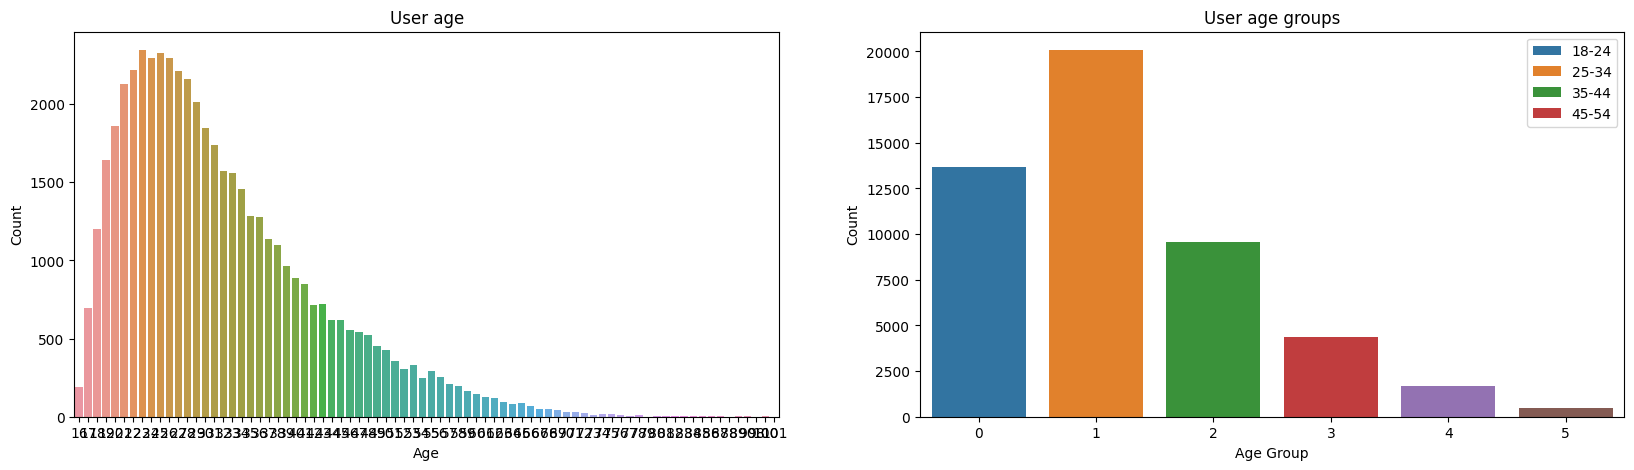

In [48]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_age = sns.countplot(data=df, x='age', ax=axes[0]).set(
                title='User age', 
                xlabel='Age', 
                ylabel='Count'
            )

plot_age_group = sns.countplot(data=df, x='age_group', ax=axes[1], hue='age_group', dodge=False)

plot_age_group.set(
                title='User age groups', 
                xlabel='Age Group', 
                ylabel='Count'
            )

legend_labels, _= plot_period.get_legend_handles_labels()
plot_age_group.legend(legend_labels, ['18-24','25-34','35-44', '45-54', '55-64', '65+']);

As predicted, the user age distribution is right-skewed! We should then use our binned age groups to train the ML model, but not before we decrease the number of groups, as ages above 45y.o. are not so frequent:

In [49]:
# age groups: (0) 18-24 (1) 25-34 (2) 35-44 (3) 45+

df['age_group'] = df['age'].apply(lambda age: ((0 if age >= 18 and age <= 24 else 1) if age <= 34 else 2) if age <= 44 else 3)

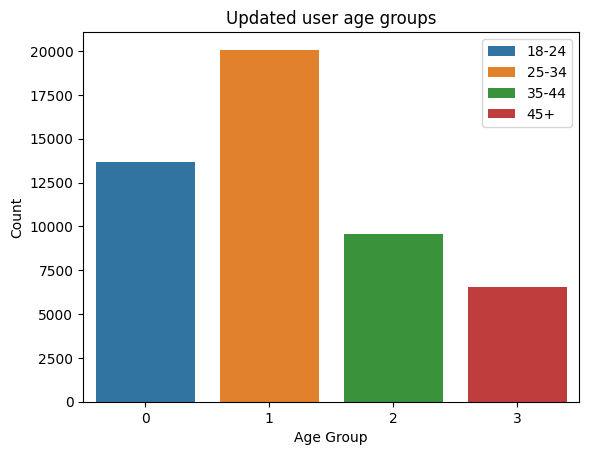

In [50]:
plot_age_group = sns.countplot(data=df, x='age_group', hue='age_group', dodge=False)

plot_age_group.set(
                title='Updated user age groups', 
                xlabel='Age Group', 
                ylabel='Count'
            )

legend_labels, _= plot_period.get_legend_handles_labels()
plot_age_group.legend(legend_labels, ['18-24','25-34','35-44', '45+'])

plt.show()

Finally, let's check the comparison between users that played the minigame and users that used premium features:

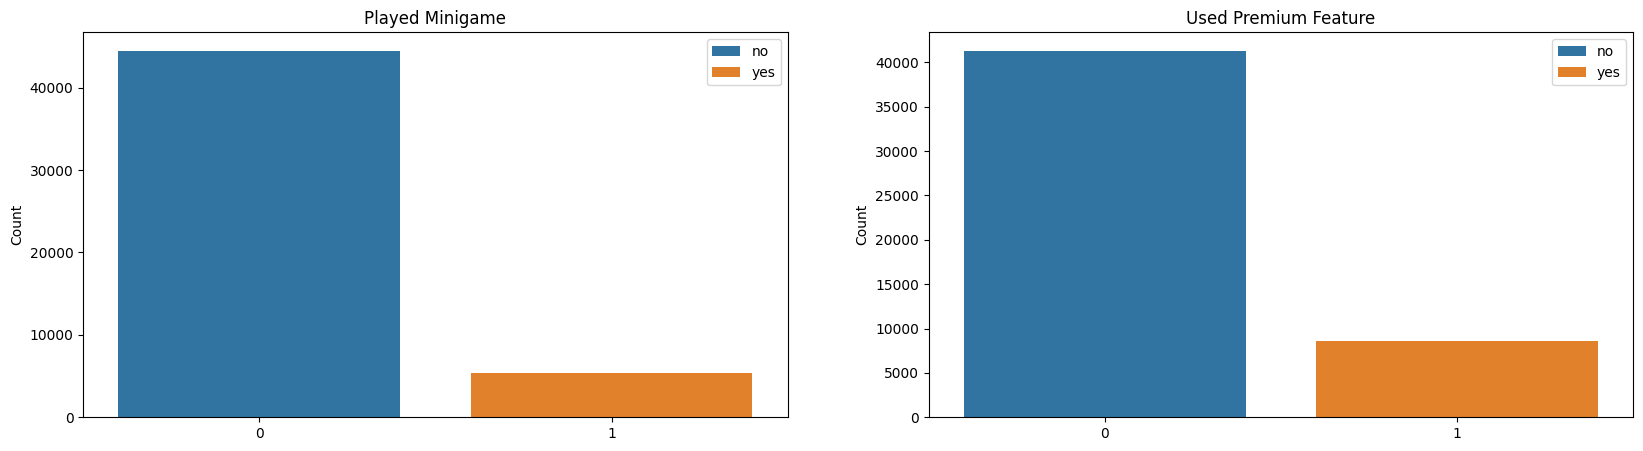

In [51]:
_, axes = plt.subplots(1, 2, figsize=(20, 5))

plot_minigame = sns.countplot(data=df, x='minigame', ax=axes[0], hue='minigame', dodge=False)

plot_minigame.set(
                title='Played Minigame', 
                xlabel='', 
                ylabel='Count'
            )

legend_labels, _= plot_minigame.get_legend_handles_labels()
plot_minigame.legend(legend_labels, ['no','yes'])

plot_used_premium = sns.countplot(data=df, x='used_premium_feature', ax=axes[1], hue='used_premium_feature', dodge=False)

plot_used_premium.set(
                title='Used Premium Feature', 
                xlabel='', 
                ylabel='Count'
            )

legend_labels, _= plot_used_premium.get_legend_handles_labels()
plot_used_premium.legend(legend_labels, ['no','yes']);

We now know that "minigame" and "used_premium_feature" are highly unbalanced categories, meaning that most of the users didn't play the app minigame nor tested any premium feature.

Last but not least, we'll check the comparison between users that enrolled or not to the app premium version:

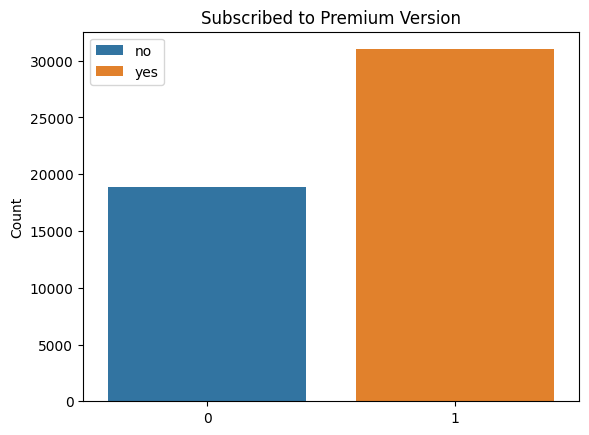

In [52]:
plot_premium = sns.countplot(data=df, x='enrolled', hue='enrolled', dodge=False)

plot_premium.set(
                title='Subscribed to Premium Version', 
                xlabel='', 
                ylabel='Count'
            )

legend_labels, _= plot_premium.get_legend_handles_labels()
plot_premium.legend(legend_labels, ['no','yes']);

The difference between users that subscribed to Premium or not lies between 20% and 30%, which for the scope of this analysis is small enough to proceed with the building of our ML algorithm.

---

## ML algorithms

It's finally time to build our ML algorithms! 

Let's create a dataframe corresponding to the features and a list corresponding to the target variable:

In [53]:
X = df.drop(['enrolled'] , axis=1)
y = df['enrolled']

And now split both into training and testing sets:

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

And create lists corresponding to the numerical and categorical features, that need to be pre-processed differently. 

In [55]:
# categorical columns
cat_cols = ['dayofweek', 'hour', 'age', 'minigame', 'used_premium_feature', 'dayperiod', 'age_group']

# numerical columns
num_cols = ['age', 'numscreens', 'total_screens', 'credit_screens', 'loan_screens', 'prof_screens', 'sav_screens', 'ver_screens', 'prod_rvw_screens']

# numerical columns from transformations
# num_cols_screens = ['total_screens', 'credit_screens', 'loan_screens', 'prof_screens', 'sav_screens', 'ver_screens', 'prod_rvw_screens']

**Data Pipeline**

We can now create a pipeline to build our models. 

First, all features are properly preprocessed depending on whether they're numerical or categorical. If they're numerical, they'll be scaled with the help of the StandardScaler. If they're categorical, they need to be one-hot encoded, that is, dummy variables need to be created.

After the preprocessor, we can apply our classifier of choice.

In [56]:
def make_pipeline(cat_cols=[], num_cols=[], classifier = RandomForestClassifier(max_depth=10)):
    
    preprocessor = ColumnTransformer(
        [
            ('ohe', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'), cat_cols),
            ('scale', StandardScaler(), num_cols)
        ]
    )

    classifier = Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('classifier', classifier)
        ]
    )
    
    return classifier
#     return preprocessor

For this analysis, we'll use Random Forest as a classifier. It's the most adequate model considering that we have many features with some correlations between them. It'll also help us to avoid overfitting, which we can later check after performing cross-validation.

In [57]:
classifier_models = [
    
    RandomForestClassifier(criterion='log_loss', max_depth=5, max_features= 5, random_state=13),
    RandomForestClassifier(criterion='log_loss', max_depth=5, max_features= 10, random_state=13),
    RandomForestClassifier(criterion='log_loss', max_depth=10, max_features= 5, random_state=13),
    RandomForestClassifier(criterion='log_loss', max_depth=10, max_features= 10, random_state=13),
    RandomForestClassifier(criterion='log_loss', max_depth=20, max_features= 5, random_state=13),
    RandomForestClassifier(criterion='log_loss', max_depth=20, max_features= 10, random_state=13),
    RandomForestClassifier(criterion='log_loss', max_depth=50, max_features= 2, random_state=13),
    RandomForestClassifier(criterion='log_loss', max_depth=50, max_features= 5, random_state=13)
    
]

Now, we'll create the pipelines for every model in our list, and check the accuracy scores with cross-validation on the training data.

In [58]:
model_results = dict()

for model in classifier_models:
    
    clf = make_pipeline(cat_cols, num_cols, model)
    
    cross_val_scores = cross_val_score(clf, X_train, y_train, cv=5)

    model_results[str(model)] = cross_val_scores

The accuracy obtained from the cross-validation can be seen in the DataFrame below:

In [59]:
df_results = pd.DataFrame(model_results)
df_results = df_results.T
df_results

,0,1,2,3,4
"RandomForestClassifier(criterion='log_loss', max_depth=5, max_features=5,\n random_state=13)",0.675188,0.661905,0.660025,0.663158,0.672641
"RandomForestClassifier(criterion='log_loss', max_depth=5, max_features=10,\n random_state=13)",0.721303,0.719925,0.716541,0.712155,0.721268
"RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=5,\n random_state=13)",0.723434,0.722180,0.725815,0.718045,0.719388
"RandomForestClassifier(criterion='log_loss', max_depth=10, max_features=10,\n random_state=13)",0.749624,0.744486,0.746115,0.740351,0.741822
"RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=5,\n random_state=13)",0.753133,0.748622,0.744862,0.742607,0.751473
"RandomForestClassifier(criterion='log_loss', max_depth=20, max_features=10,\n random_state=13)",0.782206,0.771429,0.769048,0.762782,0.776664
"RandomForestClassifier(criterion='log_loss', max_depth=50, max_features=2,\n random_state=13)",0.740226,0.742356,0.740351,0.730201,0.740444
"RandomForestClassifier(criterion='log_loss', max_depth=50, max_features=5,\n random_state=13)",0.757519,0.757018,0.752882,0.753759,0.752099


Independent on the parameters, the consistency of our scores indicate that no overfitting is present!

According to the results above, the best classifier has a max_depth of 20 and max_features of 10. Let's fit our data to this model, and then check the model score on the test data:

In [60]:
best_clf = RandomForestClassifier(criterion='log_loss', max_depth=20, max_features= 10, random_state=13)

best_clf.fit(X_train, y_train)

# store results in a dictionary 
results = best_clf.score(X_test, y_test)
results

0.7810526315789473

In [61]:
pd.DataFrame(classification_report(y_train, best_clf.predict(X_train), output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.952372,0.963880,0.958091,15144.000000
1,0.977739,0.970511,0.974112,24755.000000
accuracy,0.967994,0.967994,0.967994,0.967994
macro avg,0.965055,0.967196,0.966101,39899.000000
weighted avg,0.968111,0.967994,0.968031,39899.000000


In [62]:
pd.DataFrame(classification_report(y_test, best_clf.predict(X_test), output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.695289,0.736715,0.715403,3726.000000
1,0.837232,0.807489,0.822092,6249.000000
accuracy,0.781053,0.781053,0.781053,0.781053
macro avg,0.766261,0.772102,0.768747,9975.000000
weighted avg,0.784212,0.781053,0.782240,9975.000000


A different approach to the model parameter selection would be a parameter grid search, specified as follows:

In [63]:
parameter_grid = {
    'criterion' : ['log_loss', 'gini', 'entropy'],
    'max_depth': [10, 20, 30],
    'max_features': [2, 5, 10]
}
    
cross_validation = StratifiedKFold(n_splits=3, shuffle=True, random_state=13)

grid_search = GridSearchCV(RandomForestClassifier(random_state=13), param_grid=parameter_grid, cv=cross_validation)

grid_search.fit(X_train, y_train)
print("Best score: {}".format(grid_search.best_score_))
print("Best parameters: {}".format(grid_search.best_params_))

Best score: 0.789192731433818
Best parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 10}


The GridSearch performed in this case produced a different result, with a slightly better score comparing to our previous steps. Let's also apply this model to our dataset:

In [64]:
best_clf_grid = RandomForestClassifier(criterion='gini', max_depth=10, max_features= 10, random_state=13)

best_clf_grid.fit(X_train, y_train)

# store results in a dictionary 
results_grid = best_clf_grid.score(X_test, y_test)
results_grid

0.7869674185463659

In [65]:
pd.DataFrame(classification_report(y_train, best_clf_grid.predict(X_train), output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.737748,0.792261,0.764033,15144.000000
1,0.866898,0.827712,0.846852,24755.000000
accuracy,0.814256,0.814256,0.814256,0.814256
macro avg,0.802323,0.809986,0.805443,39899.000000
weighted avg,0.817878,0.814256,0.815417,39899.000000


In [66]:
pd.DataFrame(classification_report(y_test, best_clf_grid.predict(X_test), output_dict=True)).transpose()

,precision,recall,f1-score,support
0,0.695961,0.763017,0.727948,3726.000000
1,0.850085,0.801248,0.824944,6249.000000
accuracy,0.786967,0.786967,0.786967,0.786967
macro avg,0.773023,0.782132,0.776446,9975.000000
weighted avg,0.792514,0.786967,0.788713,9975.000000


---

## Conclusions & Outlook

Our two best RandomForest models produced a score of approximately 78,5%, which is a good preliminar result. 

But there's still some room for improvement. Here are some steps that we can implement in order to reach for a better performance:

1. Test different algorithms, as Neural Networks and XGBoost
3. Take a closer look at the user activity on the app, checking the app screens more carefully. Are there other relevant screens that can be included in our analysis?
4. Are there any other parameters that we can obtain from our data that would improve the analysis?

---